# IceCube - Neutrinos in Deep Ice
## Reconstruct the direction of neutrinos from the Universe to the South Pole
One of the most abundant particles in the universe is the neutrino. While similar to an electron, the nearly massless and electrically neutral neutrinos have fundamental properties that make them difficult to detect. Yet, to gather enough information to probe the most violent astrophysical sources, scientists must **estimate the direction of neutrino events**. If algorithms could be made considerably faster and more accurate, it would allow for more neutrino events to be analyzed, possibly even in real-time and dramatically increase the chance to identify cosmic neutrino sources. Rapid detection could enable networks of telescopes worldwide to search for more transient phenomena.

Researchers have developed multiple approaches over the past ten years to reconstruct neutrino events. However, problems arise as existing solutions are far from perfect. They're either **fast but inaccurate** or **more accurate at the price of huge computational costs**.

The IceCube Neutrino Observatory is the first detector of its kind, encompassing a cubic kilometer of ice and designed to search for the nearly massless neutrinos.

By making the process faster and more precise, we can improve the reconstruction of neutrinos. As a result, we could gain a clearer image of our universe.

The goal of this work is to **identify which direction neutrinos detected by the IceCube neutrino observatory came from**. When detection events can be localized quickly enough, traditional telescopes are recruited to investigate short-lived neutrino sources such as supernovae or gamma ray bursts. Because the sky is huge, better localization will not only associate neutrinos with sources, but also to help partner observatories limit their search space. With an average of three thousand events per second to process, it's difficult to keep up with the stream of data using traditional methods.

# Environment setup

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from IPython.display import display, Markdown

import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler

import dask.dataframe as dd

# Data understanding

## Data files and directories

In [2]:
DATA_PATH = Path("../data/raw")
TRAIN_FEATURES_PATH = DATA_PATH / "train"

In [3]:
display(Markdown(f"**Input files:**"))
!ls -p -1 $DATA_PATH | grep -v '/$'

display(Markdown(f"**Input directories:**"))
!ls -p -1 $DATA_PATH | grep '/$'

**Input files:**

sample_submission.parquet
sensor_geometry.csv
test_meta.parquet
train_meta.parquet


**Input directories:**

meta/
test/
train/


In [4]:
display(Markdown("**Train** and **test** directories contain a .parquet file for each events batch:"))
!ls $TRAIN_FEATURES_PATH -U | head -n 5

**Train** and **test** directories contain a .parquet file for each events batch:

batch_1.parquet
batch_10.parquet
batch_100.parquet
batch_101.parquet
batch_102.parquet


## Metadata insights
The metadata files contain the following fields:
* **batch_id**: the ID of the batch the event was placed into.
* **event_id**: the event ID.
* **[first/last]_pulse_index:** index of the first/last row in the features dataframe belonging to this event.
* **[azimuth/zenith]**: the azimuth/zenith angle in radians of the neutrino. A value between 0 and 2*pi for the azimuth and 0 and pi for zenith. The target columns. Not provided for the test set. The direction vector represented by zenith and azimuth points to where the neutrino came from.
* **NB**: Other quantities regarding the event, such as the interaction point in x, y, z (vertex position), the neutrino energy, or the interaction type and kinematics are not included in the dataset.

In [5]:
train_meta = pd.read_parquet(DATA_PATH / "train_meta.parquet")

In [6]:
display(Markdown("**Data types** of metadata columns"))
display(Markdown(pd.DataFrame(train_meta.dtypes, index=None).reset_index(level=0).rename(columns={'Index': 'Column', 0: 'Type'}).to_markdown(index=False)))

**Data types** of metadata columns

| index             | Type    |
|:------------------|:--------|
| batch_id          | int64   |
| event_id          | Int64   |
| first_pulse_index | int64   |
| last_pulse_index  | int64   |
| azimuth           | float64 |
| zenith            | float64 |

In [7]:
display(Markdown("Dataframe **head**"))
display(Markdown(train_meta.head().to_markdown(index=False)))

Dataframe **head**

|   batch_id |   event_id |   first_pulse_index |   last_pulse_index |   azimuth |   zenith |
|-----------:|-----------:|--------------------:|-------------------:|----------:|---------:|
|          1 |         24 |                   0 |                 60 |  5.02955  | 2.0875   |
|          1 |         41 |                  61 |                111 |  0.417742 | 1.54969  |
|          1 |         59 |                 112 |                147 |  1.16047  | 2.40194  |
|          1 |         67 |                 148 |                289 |  5.84595  | 0.759054 |
|          1 |         72 |                 290 |                351 |  0.653719 | 0.939117 |

### Batches and events

In [8]:
display(Markdown(f"**{train_meta['batch_id'].nunique()}** batches"))
display(Markdown(f"**{len(train_meta)}** events"))
display(Markdown(f"On average: **{math.floor(train_meta.groupby(train_meta['batch_id'])['event_id'].count().mean())}** events in each batch."))

**660** batches

**131953924** events

On average: **199930** events in each batch.

### Pulses

In [9]:
stat = train_meta.groupby(train_meta["batch_id"], as_index=False)["last_pulse_index"].max()

display(Markdown("Number of pulses in each batch:"))
stat.rename(columns={"batch_id": "Batch ID", "last_pulse_index": "Pulses number"}, inplace=True)
display(Markdown(stat.head().to_markdown(index=False)))
display(Markdown(f"On average: **{math.floor(stat['Pulses number'].mean())}** pulses in each batch\n"))

Number of pulses in each batch:

|   Batch ID |   Pulses number |
|-----------:|----------------:|
|          1 |     3.27924e+07 |
|          2 |     3.1948e+07  |
|          3 |     3.1697e+07  |
|          4 |     3.31871e+07 |
|          5 |     3.20759e+07 |

On average: **32867523** pulses in each batch


In [10]:
train_meta["pulses_number"] = train_meta["last_pulse_index"] - train_meta["first_pulse_index"]  + 1
display(Markdown(train_meta["pulses_number"].describe().rename("Pulses number").to_markdown()))

|       |    Pulses number |
|:------|-----------------:|
| count |      1.31954e+08 |
| mean  |    164.395       |
| std   |   1553.36        |
| min   |      5           |
| 25%   |     48           |
| 50%   |     63           |
| 75%   |     89           |
| max   | 178250           |

### Angle variables

In [11]:
display(Markdown(train_meta[["azimuth", "zenith"]].describe().to_markdown()))

|       |     azimuth |      zenith |
|:------|------------:|------------:|
| count | 1.31954e+08 | 1.31954e+08 |
| mean  | 3.14411     | 1.53442     |
| std   | 1.81351     | 0.690111    |
| min   | 6.43684e-08 | 8.63167e-05 |
| 25%   | 1.57537     | 1.00503     |
| 50%   | 3.14137     | 1.52699     |
| 75%   | 4.71762     | 2.05461     |
| max   | 6.28319     | 3.14156     |

/tmp/ipykernel_15664/107921491.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


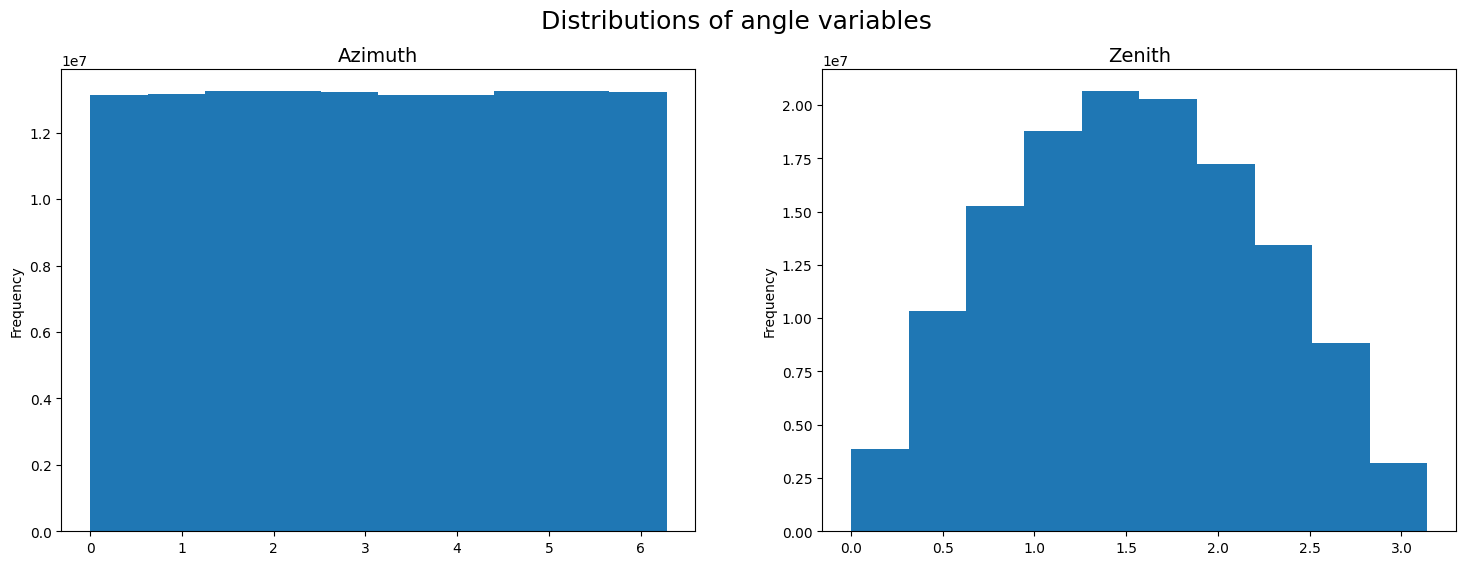

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

train_meta["azimuth"].plot(kind="hist", ax=axes[0])
train_meta["zenith"].plot(kind="hist", ax=axes[1])

axes[0].set_title("Azimuth", fontsize=14)
axes[1].set_title("Zenith", fontsize=14)

fig.suptitle("Distributions of angle variables", fontsize=18)

fig.show()

The angle variables **azimuth** and **zenith** have **no correlation**.

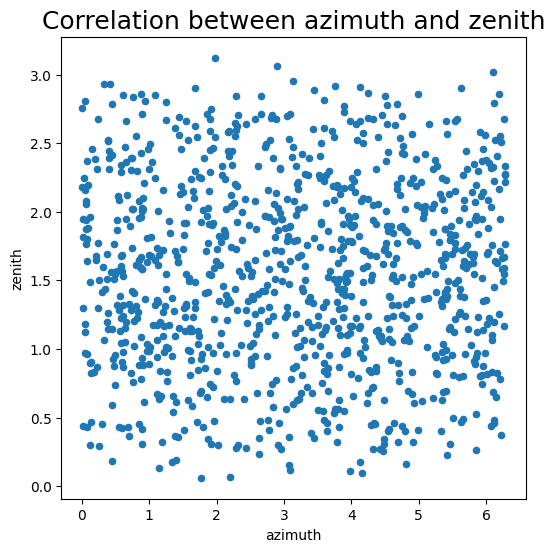

In [13]:
import random

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Correlation between azimuth and zenith", fontsize=18)

train_meta.loc[train_meta["batch_id"] == random.sample(train_meta["batch_id"].unique().tolist(), 1)[0]] \
    .sample(1000) \
    .plot(kind="scatter", x="azimuth", y="zenith", ax=ax)

display(Markdown("The angle variables **azimuth** and **zenith** have **no correlation**."))

## Sensors data insights

The **x**, **y**, and **z** positions for each of the 5160 IceCube sensors. The x, y, and z coordinates are in units of **meters**, with the origin at the center of the IceCube detector. The coordinate system is right-handed, and the z-axis points upwards when standing at the South Pole. You can convert from these coordinates to azimuth and zenith with the following formulas (here the vector (x,y,z) is normalized):
$$ x = cos(azimuth) * sin(zenith) $$
$$ y = sin(azimuth) * sin(zenith) $$
$$ z = cos(zenith) $$

In [14]:
sensors = pd.read_csv(f"{DATA_PATH}/sensor_geometry.csv")

In [15]:
display(Markdown("**Data types** of sensors data columns"))
display(Markdown(pd.DataFrame(sensors.dtypes, index=None).reset_index(level=0).rename(columns={'Index': 'Column', 0: 'Type'}).to_markdown(index=False)))

**Data types** of sensors data columns

| index     | Type    |
|:----------|:--------|
| sensor_id | int64   |
| x         | float64 |
| y         | float64 |
| z         | float64 |

In [16]:
display(Markdown("Dataframe **head**"))
display(Markdown(sensors.head().to_markdown(index=False)))

Dataframe **head**

|   sensor_id |       x |       y |      z |
|------------:|--------:|--------:|-------:|
|           0 | -256.14 | -521.08 | 496.03 |
|           1 | -256.14 | -521.08 | 479.01 |
|           2 | -256.14 | -521.08 | 461.99 |
|           3 | -256.14 | -521.08 | 444.97 |
|           4 | -256.14 | -521.08 | 427.95 |

In [17]:
display(Markdown(sensors[["x", "y", "z"]].describe().to_markdown()))

|       |          x |          y |         z |
|:------|-----------:|-----------:|----------:|
| count | 5160       | 5160       | 5160      |
| mean  |    5.87083 |   -2.51861 |  -23.9058 |
| std   |  285.151   |  269.41    |  296.457  |
| min   | -570.9     | -521.08    | -512.82   |
| 25%   | -224.09    | -209.07    | -283.2    |
| 50%   |   16.99    |   -6.055   |  -35.115  |
| 75%   |  224.58    |  211.66    |  228.558  |
| max   |  576.37    |  509.5     |  524.56   |

In [18]:
fig = px.scatter_3d(sensors, x='x', y='y', z='z', opacity=0.6, color="sensor_id")
fig.update_traces(marker_size=2)
fig.update_layout(height=600, width=600)
fig.show()

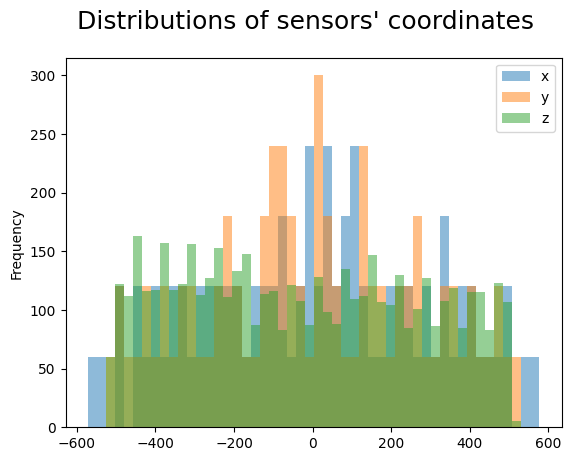

In [19]:
sensors[["x", "y", "z"]].plot(kind="hist", bins=50, alpha=0.5)
plt.suptitle("Distributions of sensors' coordinates", fontsize=18)
plt.show()

## Events data insights
Each batch contains tens of thousands of events. Each event may contain thousands of pulses, each of which is the digitized output from a photomultiplier tube and occupies one row.

* **event_id**: the event ID. Saved as the index column in parquet.
* **time**: the time of the pulse in nanoseconds in the current event time window. The absolute time of a pulse has no relevance, and only the relative time with respect to other pulses within an event is of relevance.
* **sensor_id**: the ID of which of the 5160 IceCube photomultiplier sensors recorded this pulse.
* **charge**: An estimate of the amount of light in the pulse, in units of photoelectrons (p.e.). A physical photon does not exactly result in a measurement of 1 p.e. but rather can take values spread around 1 p.e. As an example, a pulse with charge 2.7 p.e. could quite likely be the result of two or three photons hitting the photomultiplier tube around the same time. This data has float16 precision but is stored as float32 due to limitations of the version of pyarrow the data was prepared with.
* **auxiliary**: If True, the pulse was not fully digitized, is of lower quality, and was more likely to originate from noise. If False, then this pulse was contributed to the trigger decision and the pulse was fully digitized.

We browse the data on a **sample batch**.

In [20]:
batch_1_df = pd.read_parquet(f"{TRAIN_FEATURES_PATH}/batch_1.parquet")
batch_1_df.reset_index(inplace=True)

In [21]:
display(Markdown("**Data types** of data columns"))
display(Markdown(pd.DataFrame(batch_1_df.dtypes, index=None).reset_index(level=0).rename(columns={'Index': 'Column', 0: 'Type'}).to_markdown(index=False)))

**Data types** of data columns

| index     | Type    |
|:----------|:--------|
| event_id  | int64   |
| sensor_id | int16   |
| time      | int64   |
| charge    | float64 |
| auxiliary | bool    |

In [22]:
display(Markdown("Dataframe **head**"))
display(Markdown(batch_1_df.head().to_markdown(index=False)))

Dataframe **head**

|   event_id |   sensor_id |   time |   charge | auxiliary   |
|-----------:|------------:|-------:|---------:|:------------|
|         24 |        3918 |   5928 |    1.325 | True        |
|         24 |        4157 |   6115 |    1.175 | True        |
|         24 |        3520 |   6492 |    0.925 | True        |
|         24 |        5041 |   6665 |    0.225 | True        |
|         24 |        2948 |   8054 |    1.575 | True        |

In [23]:
display(Markdown(batch_1_df[["charge", "time"]].describe().to_markdown()))

|       |         charge |            time |
|:------|---------------:|----------------:|
| count |    3.27924e+07 |     3.27924e+07 |
| mean  |    3.90898     | 13130.5         |
| std   |   16.289       |  4876.8         |
| min   |    0.025       |  5714           |
| 25%   |    0.775       | 10566           |
| 50%   |    1.075       | 11815           |
| 75%   |    1.775       | 13916           |
| max   | 2762.02        | 77785           |

### Relative time

In [24]:
batch_1_df["relative_time"] = batch_1_df["time"].diff().fillna(batch_1_df["time"])

### Time and charge

We can identify **two intervals** in both graph.

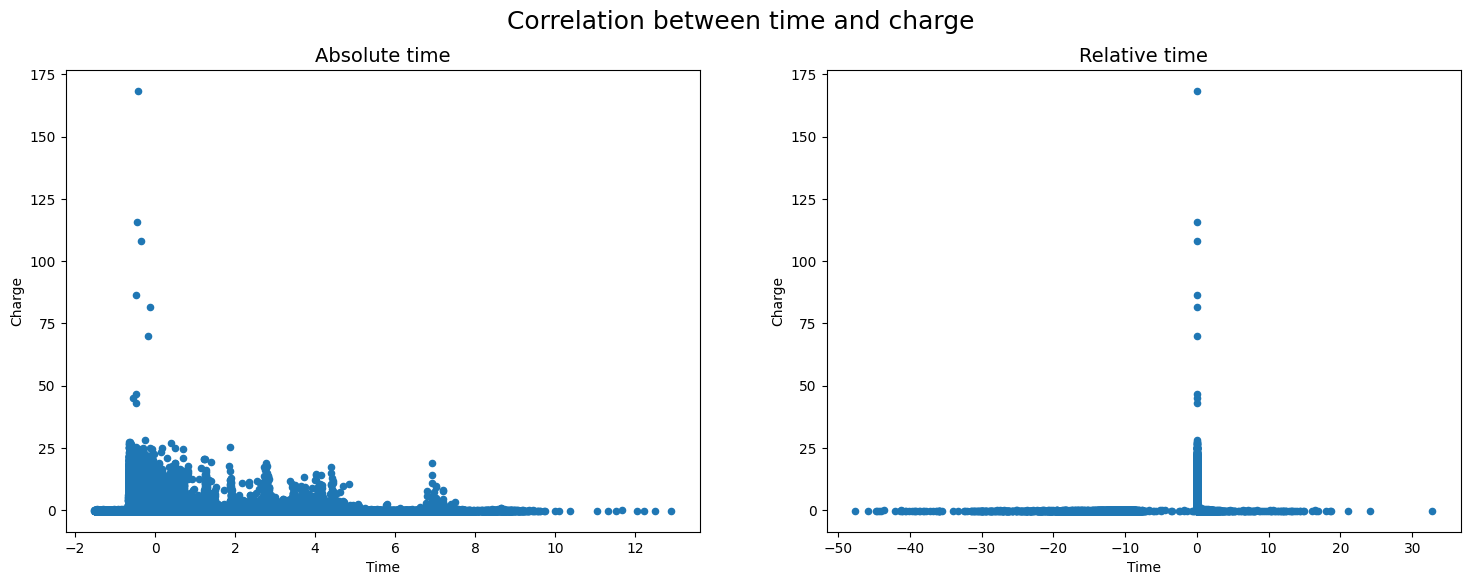

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sample = batch_1_df.sample(1000000)
sample["relative_time_scaled"] = StandardScaler().fit_transform(sample["relative_time"].values.reshape(-1, 1))
sample["time_scaled"] = StandardScaler().fit_transform(sample["time"].values.reshape(-1, 1))
sample["charge_scaled"] = StandardScaler().fit_transform(sample["charge"].values.reshape(-1, 1))

sample.plot(kind="scatter", x="time_scaled", y="charge_scaled", ax=axes[0])
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Charge")
axes[0].set_title("Absolute time", fontsize=14)

sample.plot(kind="scatter", x="relative_time_scaled", y="charge_scaled", ax=axes[1])
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Charge")
axes[1].set_title("Relative time", fontsize=14)

fig.suptitle("Correlation between time and charge", fontsize=18)

display(Markdown("We can identify **two intervals** in both graph."))

In the first interval the charge is quasi **constant**

In the second interval we notice that the charge is correlated to the duration by the **reciprocal** function

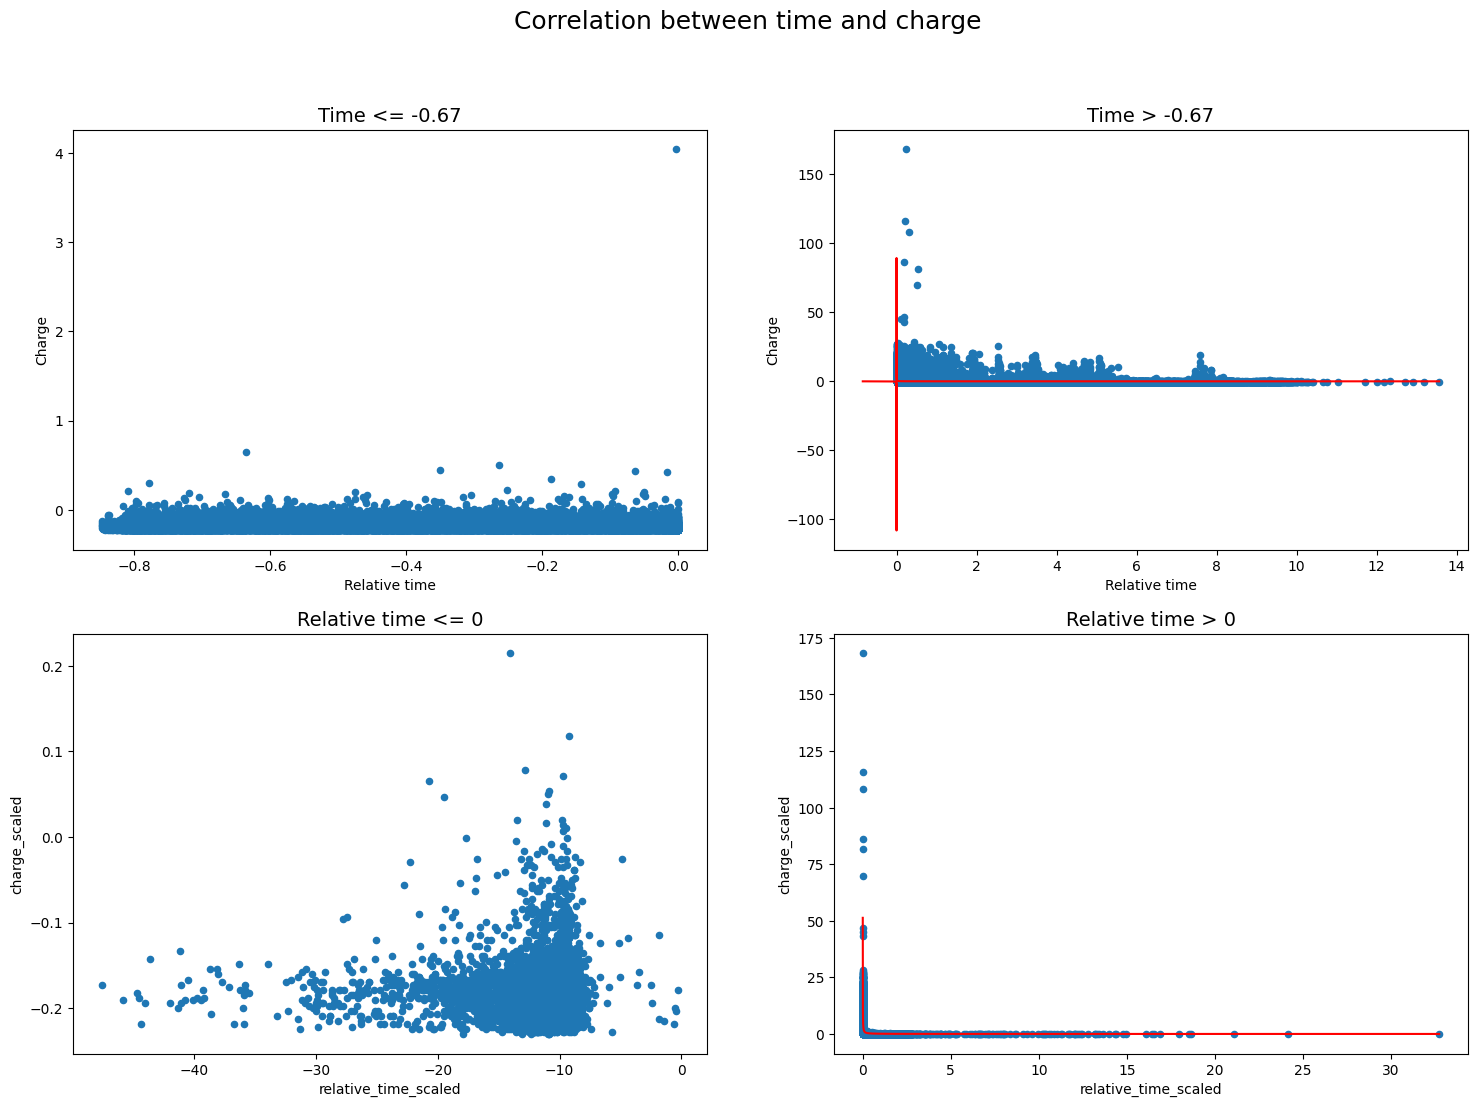

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

sample["time_scaled_moved"] = sample["time_scaled"] + 0.67

sample_neg = sample.loc[sample["time_scaled_moved"] <= 0]
sample_pos = sample.loc[sample["time_scaled_moved"] > 0]

sample_neg.plot(kind="scatter", x="time_scaled_moved", y="charge_scaled", ax=axes[0][0])
sample_pos.plot(kind="scatter", x="time_scaled_moved", y="charge_scaled", ax=axes[0][1])

sample_neg = sample.loc[sample["relative_time_scaled"] <= 0]
sample_pos = sample.loc[sample["relative_time_scaled"] > 0]

sample_neg.plot(kind="scatter", x="relative_time_scaled", y="charge_scaled", ax=axes[1][0])
sample_pos.plot(kind="scatter", x="relative_time_scaled", y="charge_scaled", ax=axes[1][1])

# approximating functions
y = 0.01 / np.sort(sample_pos["time_scaled_moved"].values)
axes[0][1].plot(np.sort(sample_pos["time_scaled_moved"].values), y, color="red")
y = 0.1 / np.sort(sample_pos["relative_time_scaled"].values)
axes[1][1].plot(np.sort(sample_pos["relative_time_scaled"].values), y, color="red")

axes[0][0].set_title("Time <= -0.67", fontsize=14)
axes[0][1].set_title("Time > -0.67", fontsize=14)
axes[1][0].set_title("Relative time <= 0", fontsize=14)
axes[1][1].set_title("Relative time > 0", fontsize=14)
for ax in axes[0]:
    ax.set_xlabel("Relative time")
    ax.set_ylabel("Charge")

fig.suptitle("Correlation between time and charge", fontsize=18)

display(Markdown("In the first interval the charge is quasi **constant**"))
display(Markdown("In the second interval we notice that the charge is correlated to the duration by the **reciprocal** function"))

## Event visualization

In [27]:
event_id = 41
event = batch_1_df.loc[batch_1_df["event_id"] == event_id]

### Merge sensor geometry and events

In [28]:
event = pd.merge(event, sensors, on="sensor_id", how="left")

### Plot

In [29]:
def charge_center(event):
    evt_sub = event[~event['auxiliary']][['x', 'y', 'z', 'charge']]
    evt_sub.loc[:, 'coef'] = evt_sub['charge'] / evt_sub['charge'].sum()

    for c in ['x', 'y', 'z']:
        evt_sub.loc[:, c] *= evt_sub['coef']
    cx, cy, cz = evt_sub[['x', 'y', 'z']].sum().values
    return cx, cy, cz

def direction(meta):
    azimuth = meta["azimuth"]
    zenith = meta["zenith"]
    dx = math.sin(zenith) * math.cos(azimuth)
    dy = math.sin(zenith) * math.sin(azimuth)
    dz = math.cos(zenith)
    return dx, dy, dz

In [30]:
from plotly.subplots import make_subplots

scale = 750
fig = make_subplots(
    rows=1, specs=[[{'type': 'scene'}]],
    vertical_spacing=0.05,
)
fig.add_trace(go.Scatter3d(x=sensors['x'], y=sensors['y'], z=sensors['z'], mode='markers', marker=dict(size=1, color="black"), opacity=0.2))
fig.add_trace(
    go.Scatter3d(
        x=event['x'], y=event['y'], z=event['z'], 
        opacity=0.8, 
        mode='markers', marker=dict(size=event['charge'] * 15, color=event['time'], colorscale='sunsetdark')), 
    row=1, col=1)

meta = dict(train_meta[train_meta["event_id"] == event_id].iloc[0])
dx, dy, dz = direction(meta)
cx, cy, cz = charge_center(event)

fig.add_trace(
    go.Scatter3d(
        x=[cx - dx * scale, cx + dx * scale],
        y=[cy - dy * scale, cy + dy * scale],
        z=[cz - dz * scale, cz + dz * scale],
        opacity=0.8, mode='lines', line=dict(color='red', width=3)
    ), row=1, col=1)

In [31]:
stat = event.groupby(event["sensor_id"]).agg({'sensor_id': ['count']})
stat.loc[stat["sensor_id"]["count"] > 1]

,sensor_id
,count
sensor_id,
3140,3
4107,3
4502,2
4503,2
